In [10]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [11]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

In [12]:

tickers = ['AAPL', 'GOOG', 'TSLA']

end_date = datetime.today()
start_date = end_date - timedelta(days=730)

data = yf.download(
    tickers=tickers,
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval='1d',
    group_by='ticker',
    auto_adjust=False,
    threads=True
)
print(data.head())

[*********************100%***********************]  3 of 3 completed

Ticker            AAPL                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2023-06-01  177.699997  180.119995  176.929993  180.089996  178.304764   
2023-06-02  181.029999  181.779999  179.259995  180.949997  179.156219   
2023-06-05  182.630005  184.949997  178.039993  179.580002  177.799805   
2023-06-06  179.970001  180.119995  177.429993  179.210007  177.433487   
2023-06-07  178.440002  181.210007  177.320007  177.820007  176.057281   

Ticker                       GOOG                                      \
Price          Volume        Open        High         Low       Close   
Date                                                                    
2023-06-01   68901800  123.500000  125.040001  123.300003  124.370003   
2023-06-02   61945900  124.489998  126.745003  124.349998  125.230003   
2023-06-05  121946500  124.610001  127.989

In [13]:
import numpy as np
import matplotlib.pyplot as plt

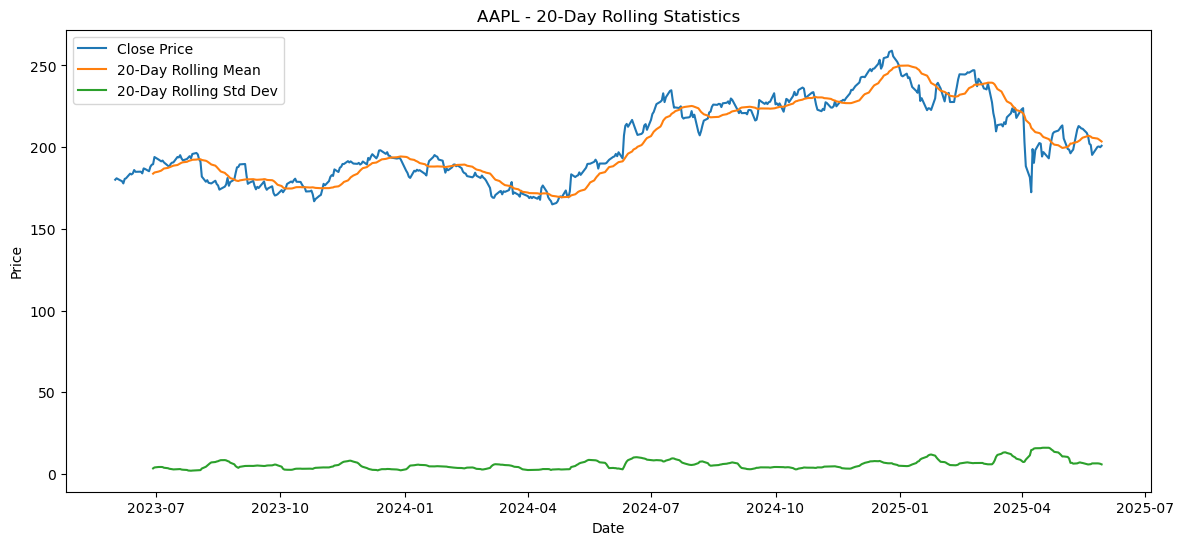

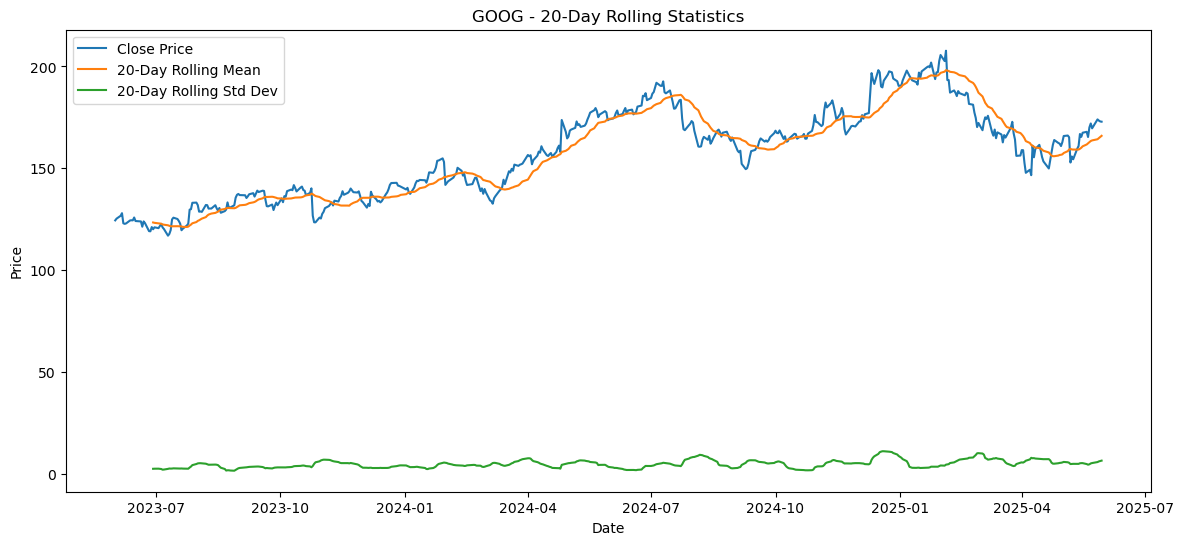

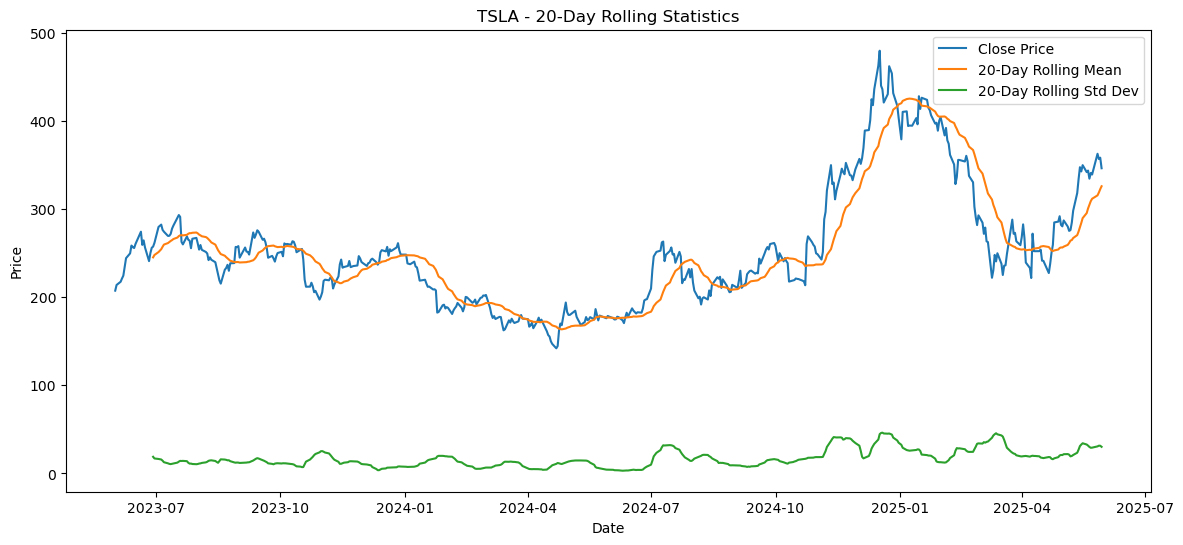

In [14]:
arithmetic_returns = {}
log_returns = {}
for ticker in tickers:
    close_prices = data[ticker]['Close']
    arithmetic_returns[ticker] = close_prices.pct_change()
    log_returns[ticker] = np.log(close_prices / close_prices.shift(1))
    

for ticker in tickers:
    close_prices = data[ticker]['Close']
    rolling_mean = close_prices.rolling(window=20).mean()
    rolling_std = close_prices.rolling(window=20).std()

    plt.figure(figsize=(14, 6))
    plt.plot(close_prices.index, close_prices, label='Close Price')
    plt.plot(rolling_mean.index, rolling_mean, label='20-Day Rolling Mean')
    plt.plot(rolling_std.index, rolling_std, label='20-Day Rolling Std Dev')
    plt.title(f'{ticker} - 20-Day Rolling Statistics')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

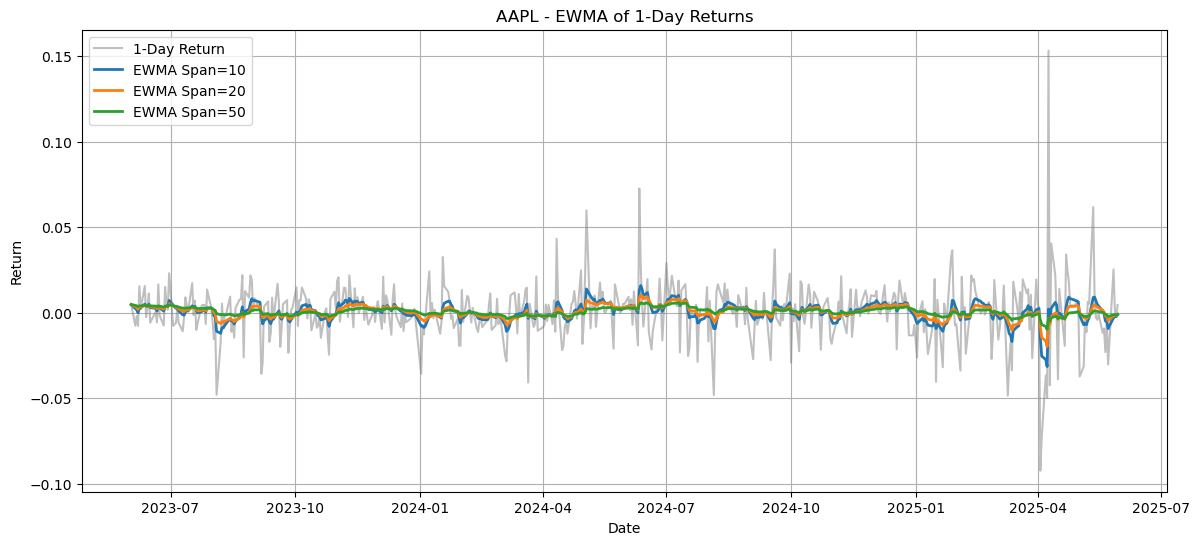

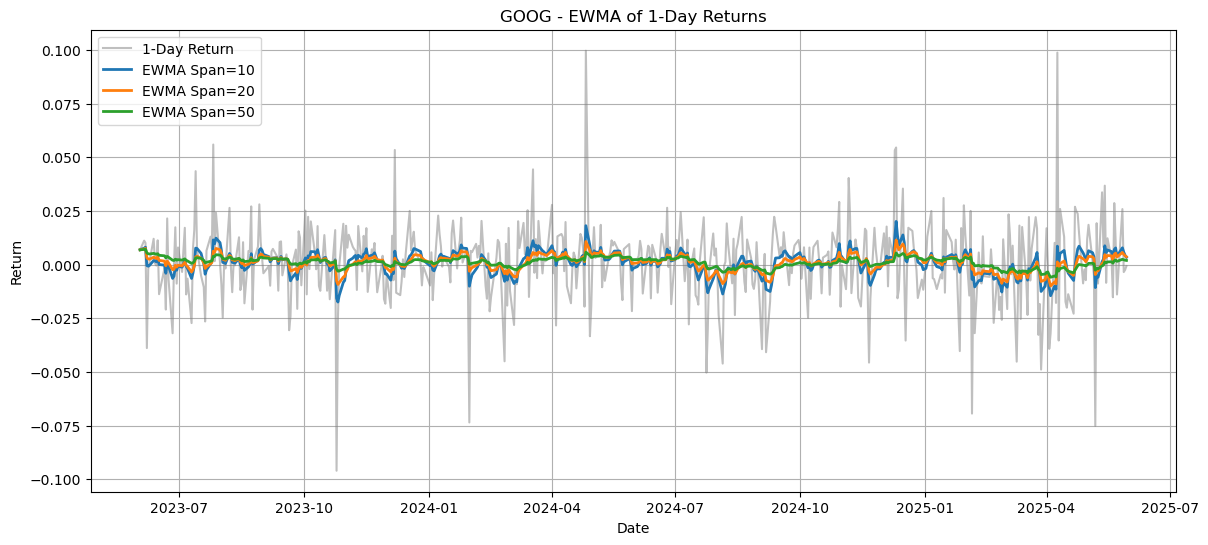

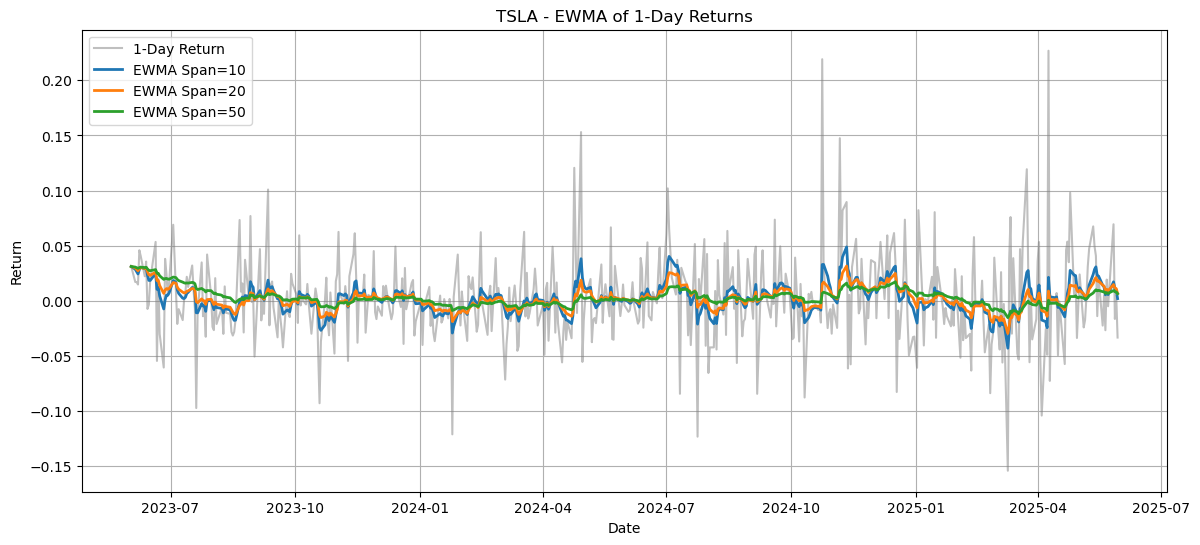

In [15]:
#ewma
for ticker in tickers:
    ticker_return = arithmetic_returns[ticker].dropna()
    ewma_10 = ticker_return.ewm(span=10, adjust=False).mean()
    ewma_20 = ticker_return.ewm(span=20, adjust=False).mean()
    ewma_50 = ticker_return.ewm(span=50, adjust=False).mean()

    plt.figure(figsize=(14, 6))
    plt.plot(ticker_return.index, ticker_return, label='1-Day Return', color='gray', alpha=0.5)
    plt.plot(ewma_10.index, ewma_10, label='EWMA Span=10', linewidth=2)
    plt.plot(ewma_20.index, ewma_20, label='EWMA Span=20', linewidth=2)
    plt.plot(ewma_50.index, ewma_50, label='EWMA Span=50', linewidth=2)
    plt.title(f'{ticker} - EWMA of 1-Day Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
#momentum

features = {}

for ticker in tickers:
    close_prices = data[ticker]['Close']
    arith_ret = arithmetic_returns[ticker]
    
    momentum_5 = close_prices.pct_change(periods=5)
    momentum_21 = close_prices.pct_change(periods=21)
    
    rv20 = arith_ret.rolling(window=20).std() * np.sqrt(252)
    
    df = pd.DataFrame({
        'momentum_5': momentum_5,
        'momentum_21': momentum_21,
        'rv20': rv20
    })
    
    features[ticker] = df


combined_features = pd.concat(features, axis=1)
print(combined_features.dropna().head())

                 AAPL                             GOOG                        \
           momentum_5 momentum_21      rv20 momentum_5 momentum_21      rv20   
Date                                                                           
2023-07-03   0.038808    0.068688  0.155470   0.012344   -0.030634  0.246245   
2023-07-05   0.017388    0.057364  0.154028   0.030418   -0.020762  0.251293   
2023-07-06   0.013527    0.068103  0.152800  -0.001239   -0.045013  0.251033   
2023-07-07   0.005749    0.064003  0.151121   0.001083   -0.060746  0.212524   
2023-07-10  -0.027633    0.060679  0.152449  -0.033893   -0.049374  0.231960   

                 TSLA                        
           momentum_5 momentum_21      rv20  
Date                                         
2023-07-03   0.160838    0.348400  0.523452  
2023-07-05   0.128972    0.320185  0.523562  
2023-07-06   0.079223    0.270806  0.537548  
2023-07-07   0.065748    0.240025  0.541746  
2023-07-10   0.029950    0.200561  0.

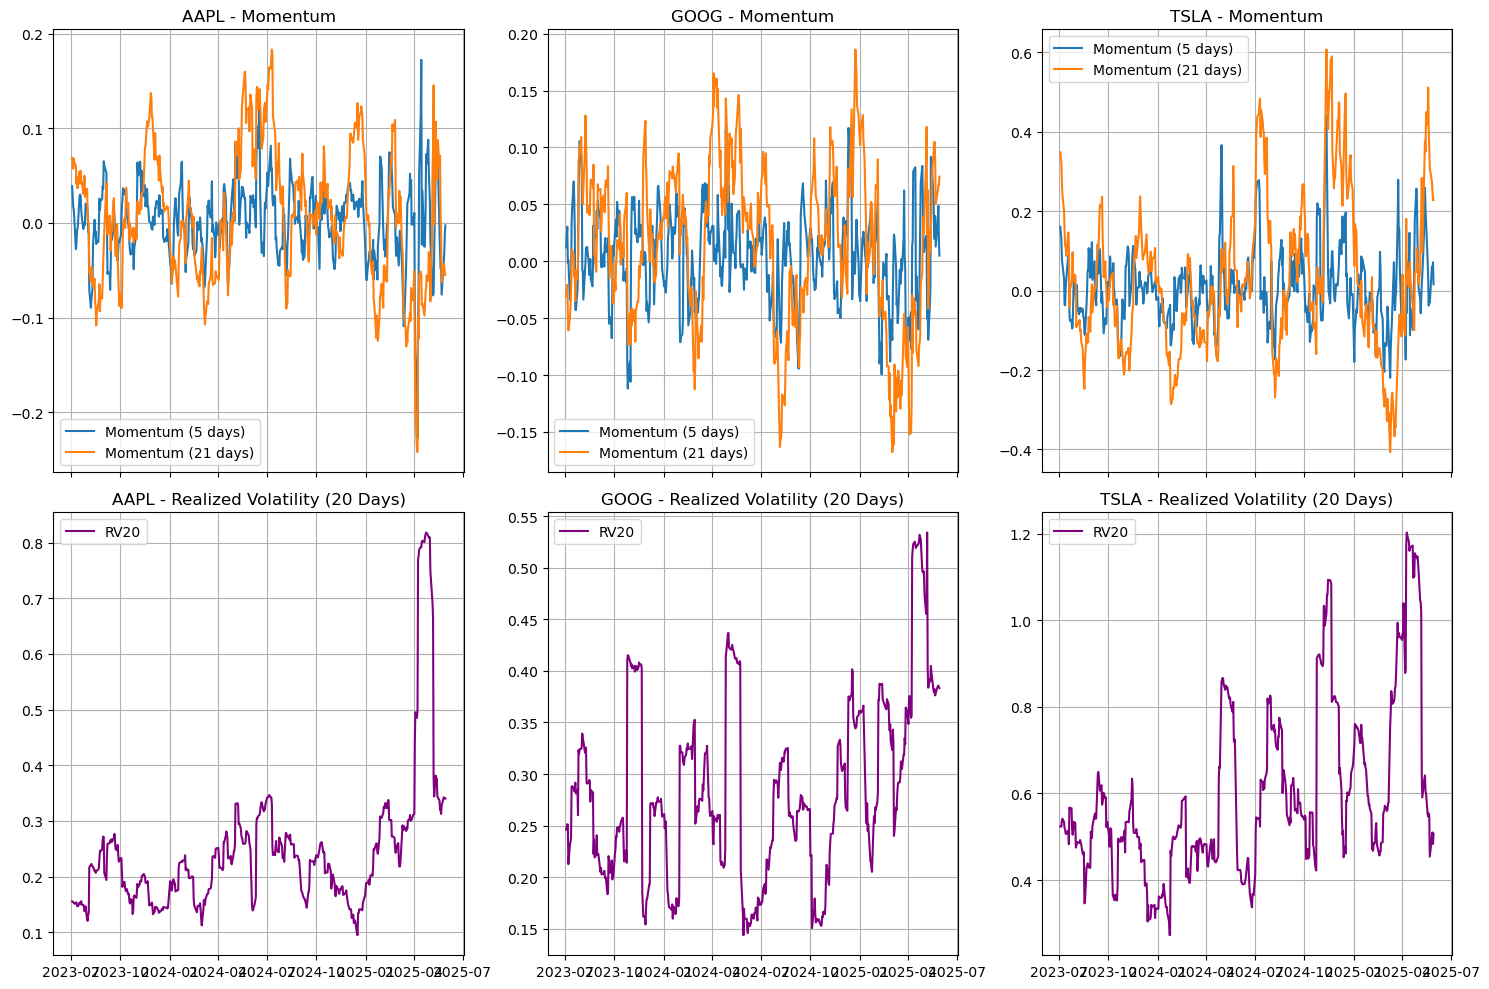

In [21]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

for col_idx, ticker in enumerate(tickers):
    df = features[ticker].dropna()
    
    # Row 1: momentum (overlay 5-day and 21-day)
    axes[0, col_idx].plot(df.index, df['momentum_5'], label='Momentum (5 days)')
    axes[0, col_idx].plot(df.index, df['momentum_21'], label='Momentum (21 days)')
    axes[0, col_idx].set_title(f"{ticker} - Momentum")
    axes[0, col_idx].legend()
    axes[0, col_idx].grid(True)
    
    # Row 2: realized volatility
    axes[1, col_idx].plot(df.index, df['rv20'], label='RV20', color='purple')
    axes[1, col_idx].set_title(f"{ticker} - Realized Volatility (20 Days)")
    axes[1, col_idx].legend()
    axes[1, col_idx].grid(True)

plt.tight_layout()
plt.show()

Momentum
AAPL
    (for both 5-day and 21-day) fluctuates but stays mostly between [-0.1, 0.1]. Fairly stable
GOOG
    Similar to AAPL but there are occasional sharper spikes (5-day) => appears slightly more responsive to mkt news (?). 
TSLA
    In comparison has much bigger swings => reacts strongly to narrative shifts, which result in intense but short periods of selling/buying. Difference between 5-day and 21-day momentums are more pronounced => most of these periods don't persist for a long time. 

Volatility
AAPL
    Low volatility generally, except for spike in '25 April (due to announcement of tariffs??). Possibly better defensive asset
GOOG
    Slightly more volatility, similar spike in '25 April. 
TSLA
    Much more volatile, frequent spikes (matches observations from momentum profile).


Data quality issues:
    There seems to be no missing data and extremes on price values seem reasonable. 

In [25]:
# data quality checks

# check if there is missing data
for ticker in tickers:
    percent_missing = data[ticker].isna().mean() * 100
    print(f"percent of missing data for {ticker} \n{percent_missing}\n")

# sanity check on price values
for ticker in tickers:
    close_prices = data[ticker]['Close']
    print(f"{ticker} min: {close_prices.min()}, max: {close_prices.max()}")

percent of missing data for AAPL 
Price
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

percent of missing data for GOOG 
Price
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

percent of missing data for TSLA 
Price
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

AAPL min: 165.0, max: 259.0199890136719
GOOG min: 116.87000274658203, max: 207.7100067138672
TSLA min: 142.0500030517578, max: 479.8599853515625
